In [15]:
#Imports
import cv2
import glob
import numpy as np 
from matplotlib import pyplot as plot 
from matplotlib import image as image
import easygui 

In [6]:
#Global variables
letter_to_img = {}
letters = "ABCDEFGJLMNOPRTUV"

In [7]:
#Function to add all letter found in folder "./Images/Letter-Images/*.png" into an array of images
#This array of images is then added to a dictionary to reference the value 
def create_letter_image_dict():
    letterimages = [cv2.imread(file) for file in glob.glob("./Images/Letter-Images/*.png")]
    for index in range(0, len(letterimages)):
        letter_to_img[letters[index]] = letterimages[index]

In [8]:
def imageViewerPOPOUT(imagename, img):
    print("Window opened!")
    cv2.imshow(imagename, img)
#For manual closing of windows
    key = cv2.waitKey(0)
#For automatic closing of windows
#     key = cv2.waitKey(80)
#     cv2.destroyWindow(imagename)
    print("Window closed")

In [9]:
def resizeImg(img):
    h, w, d = img.shape
    h1 = int(h/4)
    w1 = int(w/4)
    S = cv2.resize(img, dsize=(h1, w1))
    return S

In [220]:
def main():
    create_letter_image_dict()
    easygui.msgbox("Please select a image")
    f = easygui.fileopenbox()

    if(f == None ):
        while(f == None):
            print("Error reading in file")
            easygui.msgbox("Please select a file")
            f = easygui.fileopenbox()
        
    I = cv2.imread(f)
    ReisizedImg = resizeImg(I)
    crop_lid(ReisizedImg)
#     imageViewerPOPOUT("Image selected", ReisizedImg)

In [219]:
def crop_lid(Mooju):
    I = Mooju.copy()
    BlurredCopy = cv2.GaussianBlur(I, (7,7), 0)
    CannnyImage = canny_edge_Detection(BlurredCopy, 0, 255)
    
    contours,_ = cv2.findContours(CannnyImage, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    x,y,w,h = cv2.boundingRect(contours[0])
    crop_img = I[y:y+h, x:x+w]
    
#     I = cv2.drawContours(I, contours, 0, color=(0,0,0), thickness=3)
    subplot_images([CannnyImage, BlurredCopy, I, crop_img])
    return crop_img

In [147]:
def convert_To_RGB(img):
    RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return RGB

def convert_To_GrayScale(img):
    GRAY = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return GRAY

def canny_edge_Detection(I, lowvalue, highvalue):
    FilteredImage = cv2.Canny(I, threshold1=lowvalue, threshold2=highvalue)
    return FilteredImage

def calc_subplot(amount):
    if amount == 1:
        return 1,1
    
    for i in range(1,amount):
        if amount % i == 0:
            cols = int(amount / i)
            rows = i
    
    return rows, cols

def subplot_images(Images):
    amount = len(Images)
    rows, columns  = calc_subplot(amount)

    fig=plot.figure(figsize=(16, 16))
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        if(len(Images[i-1].shape)!=3):
            plot.imshow(Images[i-1], cmap='gray')
        else:
            plot.imshow(convert_To_RGB(Images[i-1]))
        
    plot.show()
    

def multiple_thresholding(I, rangelower, rangehigher):
    B = cv2.inRange(I, rangelower, rangehigher)
    return B

In [222]:
def testmain():
#     MoojuLids = [cv2.imread(file) for file in glob.glob("./Images/MoojuLids/*.png")]
    Mooju = cv2.imread("./Images/MoojuLids/mooju.jpg")
    ReisizedImg = resizeImg(Mooju)
    crop_lid(ReisizedImg)

    

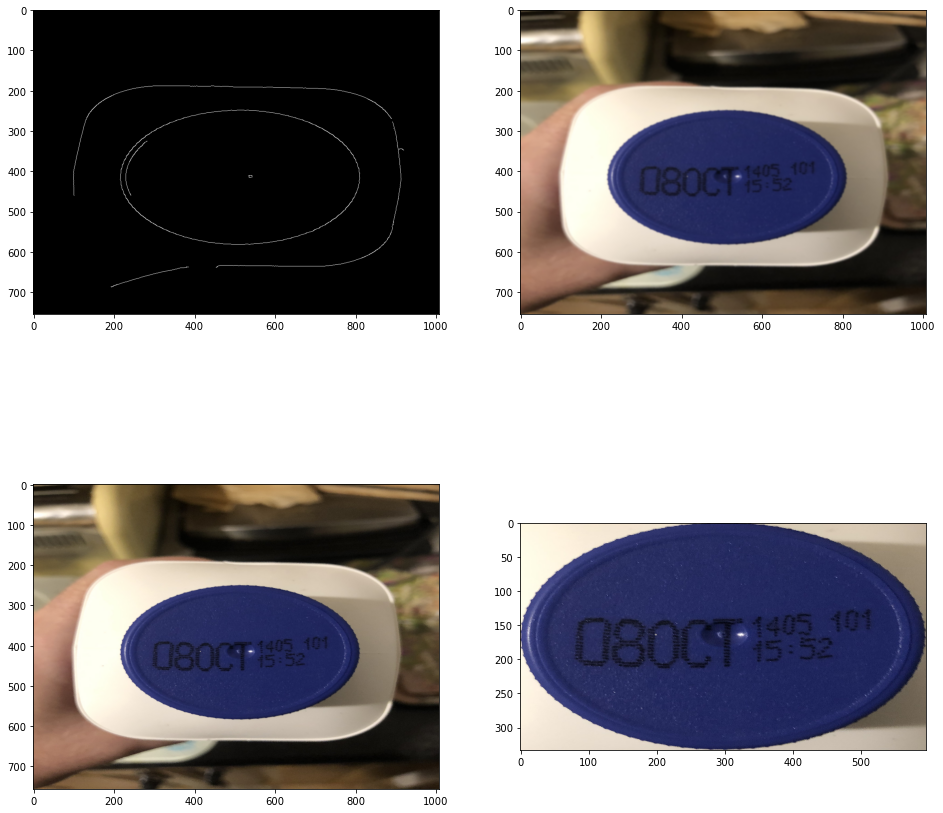

In [223]:
#This runs when program is started
if __name__ == "__main__":
#     main()

#This is for testing all lids 
#     MoojuLids = [cv2.imread(file) for file in glob.glob("./Images/MoojuLids/*.jpg")]
#     for Mooju in MoojuLids:
    testmain()

        